<a href="https://colab.research.google.com/github/Arsuh/Seq2Seq-Chatbot/blob/master/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Arsuh/Seq2Seq-Chatbot

In [0]:
from __future__ import absolute_import, division, print_function
%tensorflow_version 2.x
import tensorflow as tf

from google.oauth2 import service_account
from google.cloud import bigquery

import matplotlib.pyplot as plt
import numpy as np
import json
import re
import os
import time
import random

TensorFlow 2.x selected.


In [0]:
main_path = '/content/Seq2Seq-Chatbot/'
#hparams_path = main_path + 'hyper_parameters_std.json'
hparams_path = main_path + 'hyper_parameters_test.json'
credentials_path = main_path + 'credentials.json'
ckpt_path = main_path + 'ckeckpoints/'
ckpt_prefix = os.path.join(ckpt_path, 'ckpt')

In [0]:
class Vocabulary(object):
    PAD = '<PAD>'  # INDEX: 0
    SOS = '<SOS>'  # INDEX: 1
    EOS = '<EOS>'  # INDEX: 2
    UNK = '<UNK>'  # INDEX: 3
    special_tokens = [PAD, SOS, EOS, UNK]

    def __init__(self, max_len=150, dictionary_size=None):
        self.max_len = max_len
        self.word2idx = {}
        self.idx2word = {}
        self.word_occurrence = {}
        self.current_index = 4
        self.dict_size = dictionary_size

        self.inp = []
        self.tar = []
        self.tokenized = False

        for nr, word in enumerate(Vocabulary.special_tokens):
            self.word2idx[word] = nr
            self.idx2word[nr] = word

# -------------------MAIN-FUNCTIONS-------------------------

    def create_index(self, text, creating_indices=True):
        if not isinstance(text, str):
            text = ''.join(map(str, text))

        text = text.strip()
        for word in text.split(' '):
            if word in self.word_occurrence:
                self.word_occurrence[word] += 1
            else:
                self.word_occurrence[word] = 1

        if self.dict_size != None:
            self.sort_by_occurence()
            self.remove_words()

        if creating_indices:
            for word in self.word_occurrence:
                self.word2idx[word] = self.current_index
                self.idx2word[self.current_index] = word
                self.current_index += 1

    def add_words(self, text):
        for word in text:
            if word in self.word_occurrence:
                self.word2idx[word] = self.current_index
                self.idx2word[self.current_index] = word
                self.current_index += 1

    def add_words_aux(self, text, aux_vocab):
        for word in text.split(' '):
            if word not in aux_vocab:
                aux_vocab.append(word)
                self.word2idx[word] = self.current_index
                self.idx2word[self.current_index] = word
                self.current_index += 1

        return aux_vocab

    def remove_words(self):
        i = 0
        rem = []
        for word in self.word_occurrence:
            i += 1
            if i > self.dict_size:
                rem.append(word)

        for itm in rem:
            del self.word_occurrence[itm]

    def size(self):
        return len(self.word_occurrence)

    def word_exists(self, word):
        return word in self.word_occurrence

    def sort_by_occurence(self):
        self.word_occurrence = {k: v for k, v in sorted(
            self.word_occurrence.items(), key=lambda item: item[1], reverse=True)}

    def decode_text(self, enc_text, remove_borders=False):
        dec_text = []
        for idx in enc_text:
            # dec_text.append(self.idx2word[idx])

            if remove_borders:
                if idx == 1 and idx == 2:
                    continue

            if idx in self.idx2word and idx != 0:
                #dec_text += self.idx2word[idx] + ' '
                dec_text.append(self.idx2word[idx])

        return dec_text

    def encode_text(self, dec_text):
        if not isinstance(dec_text, str):
            dec_text = ''.join(map(str, dec_text))

        #dec_text = Vocabulary.punctuate_text(dec_text)
        #dec_text = Vocabulary.normalize_text(dec_text)
        dec_text = self.integrate_special_tokens(dec_text)

        enc_text = []
        for word in dec_text.split(' '):
            if word in self.word_occurrence:
                enc_text.append(self.word2idx[word])
            elif word in Vocabulary.special_tokens:
                enc_text.append(Vocabulary.special_tokens.index(word))

        return enc_text

    def pad_text(self, enc_text):
        while len(enc_text) < self.max_len:
            enc_text.append(0)  # PAD
        return enc_text

    def get_final_text(self, enc_text):
        if len(enc_text) > self.max_len:
            enc_text = enc_text[:self.max_len - 1]
            enc_text.append(2)  # EOS
        elif len(enc_text) < self.max_len:
            enc_text = self.pad_text(enc_text)

        return enc_text

    def preproc(self, text):
        text = Vocabulary.punctuate_text(text)
        text = Vocabulary.normalize_text(text)
        text = Vocabulary.normalize_numbers(text)
        text = self.encode_text(text)
        text = self.get_final_text(text)
        return text

    def tokenize_data(self):
        if self.tokenized == False:
            i = 0
            for _ in self.inp:
                enc_text = self.encode_text(self.inp[i])
                self.inp[i] = self.get_final_text(enc_text)
                enc_text = self.encode_text(self.tar[i])
                self.tar[i] = self.get_final_text(enc_text)
                i += 1
            self.tokenized = True

    def de_tokenize_data(self):
        if self.tokenized == True:
            i = 0
            for _ in self.inp:
                self.inp[i] = self.decode_text(self.inp[i])
                self.tar[i] = self.decode_text(self.tar[i])

                j = 0
                while j < len(self.inp[i]):
                    if self.inp[i][j] in Vocabulary.special_tokens[:-1]:
                        del self.inp[i][j]
                        j -= 1
                    j += 1

                j = 0
                while j < len(self.tar[i]):
                    if self.tar[i][j] in Vocabulary.special_tokens[:-1]:
                        del self.tar[i][j]
                        j -= 1
                    j += 1
                i += 1
            self.tokenized = False

    def print_data(self):
        print(' >>> VOCAB_SIZE: {}\n >>> CURENT INDEX: {}'.format(
            self.dict_size, self.current_index))

# ----------------SAVING/LOADING-DATA---------------------

    def save_csv(self, path, save_index=True):
        total_words = self.size()
        with open(path, 'w', encoding='utf-8') as f:
            if save_index:
                f.write('word,index,occurrence\n')
                for i in range(4, total_words):
                    word = self.idx2word[i]
                    occurrence = self.word_occurrence[word]
                    f.write('{},{},{}\n'.format(word, i, occurrence))
            else:
                f.write('word,occurrence\n')
                for word in self.word_occurrence:
                    f.write('{},{}\n'.format(word, self.word_occurrence[word]))

    @staticmethod
    def load_csv(path, word_occ_only=False, limit=None, verbose=True):
        v = Vocabulary()
        with open(path, 'r', encoding='utf-8') as f:
            i = 1
            for line in f.readlines()[1:]:
                text = line.split(',')
                if word_occ_only == False:
                    v.word2idx[text[0]] = text[1]
                    v.idx2word[text[1]] = text[0]
                    v.word_occurrence[text[0]] = int(text[2][:-1])
                else:
                    v.word_occurrence[text[0]] = int(text[1][:-1])

                if limit != None and i > limit:
                    break
                if verbose and i % 200000 == 0:
                    print('{} rows added to vocabulary!'.format(i))
                i += 1

        sz = v.size()
        v.current_index = sz + 1
        # vocabulary.dict_size = sz
        return v

    @staticmethod
    def create_query(sql, credentials):
        try:
            client = bigquery.Client(
                credentials=credentials, project=credentials.project_id,)

            return client.query(sql).result()

        except Exception as e:
            print(e)

    def load_bigquery_main_vocab(self, credentials, limit=None, verbose=True):
        """ Used only for creating intitial vocabulary """
        query = 'SELECT parent, comment FROM `reddit-chatobot.Reddit_db.mainTable`'
        if limit != None:
            query += ' LIMIT {}'.format(limit)

        i = 1
        rows = Vocabulary.create_query(query, credentials)
        for row in rows:
            parent = Vocabulary.punctuate_text(str(row.parent))
            parent = Vocabulary.normalize_text(parent)
            self.create_index(parent, creating_indices=False)
            comment = Vocabulary.punctuate_text(str(row.comment))
            comment = Vocabulary.normalize_text(comment)
            self.create_index(comment, creating_indices=False)

            if verbose and i % 200000 == 0:
                print('   >>> {} rows done!'.format(i))
            i += 1

        sz = self.size()
        self.current_index = sz + 1
        # vocabulary.dict_size = sz
        if verbose:
            self.print_data()

    def load_bigquery_main(self, credentials, limit=None, verbose=True):
        query = 'SELECT parent, comment FROM `reddit-chatobot.Reddit_db.mainTable`'
        if limit != None:
            query += ' LIMIT {}'.format(limit)

        i = 1
        rows = Vocabulary.create_query(query, credentials)
        aux_vocab = []
        for row in rows:
            parent = Vocabulary.punctuate_text(str(row.parent))
            parent = Vocabulary.normalize_text(parent)
            parent = Vocabulary.normalize_numbers(parent)
            aux_vocab = self.add_words_aux(parent, aux_vocab)

            comment = Vocabulary.punctuate_text(str(row.comment))
            comment = Vocabulary.normalize_text(comment)
            comment = Vocabulary.normalize_numbers(comment)
            aux_vocab = self.add_words_aux(comment, aux_vocab)

            if verbose and i % 200000 == 0:
                print('   >>> {} rows done!'.format(i))
            i += 1

        del aux_vocab

    def load_bigquery_vocab(self, credentials, vocab='no_ap', limit=None, verbose=True):
        if vocab == 'no_ap':
            query = 'SELECT word, occurrence FROM `reddit-chatobot.Reddit_db.lim_vocab_no_ap`'
        elif vocab == 'ap':
            query = 'SELECT word, occurrence FROM `reddit-chatobot.Reddit_db.lim_vocab`'
        else:
            raise Exception('Unknown vocab argument! Use \'no_ap\' or \'ap\'!')

        if limit != None:
            query += ' LIMIT {}'.format(limit)

        i = 1
        rows = Vocabulary.create_query(query, credentials)
        try:
            for row in rows:
                word = str(row.word)
                occ = int(row.occurrence)
                self.word_occurrence[word] = occ

                if verbose and i % 200000 == 0:
                    print('   >>> {} rows done!'.format(i))
                i += 1

            if verbose:
                print('Word occurrence created!')
        except Exception as e:
            print(e)

    def load_bigquery_vocab_from_indexed(self, credentials, vocab='no_ap', limit=None, verbose=True):
        if vocab == 'no_ap':
            query = 'SELECT * FROM `reddit-chatobot.Reddit_db.vocab_no_ap_indexed`'
        elif vocab == 'ap':
            query = 'SELECT * FROM `reddit-chatobot.Reddit_db.vocab_ap_indexed`'
        else:
            raise Exception('Unknown vocab argument! Use \'no_ap\' or \'ap\'!')

        if limit != None:
            query += ' LIMIT {}'.format(limit)

        i = 1
        rows = Vocabulary.create_query(query, credentials)
        try:
            for row in rows:
                word = str(row.word)
                occ = int(row.occurrence)
                idx = int(row.idx)
                self.word_occurrence[word] = occ
                self.word2idx[word] = idx
                self.idx2word[idx] = word

                if verbose and i % 200000 == 0:
                    print('   >>> {} rows done!'.format(i))
                i += 1

            if verbose:
                print('Word occurrence created!')
        except Exception as e:
            print(e)

    @staticmethod
    def load_bigquery_full(credentials, max_len=150, vocab='no_ap', limit_main=None, limit_vocab=None, verbose=True):
        v = Vocabulary(max_len=max_len)
        v.load_bigquery_main(credentials, limit_main, verbose)
        v.load_bigquery_vocab(credentials, vocab, limit_vocab, verbose)
        v.dict_size = v.size()

        if verbose:
            v.print_data()
        return v

    @staticmethod
    def create_inputs(credentials, max_len=150, vocab='no_ap', limit_main=None, limit_vocab=None, verbose=True):
        v = Vocabulary(max_len=max_len)
        v.load_bigquery_vocab(credentials, vocab, limit_vocab, verbose)

        query = 'SELECT * FROM `reddit-chatobot.Reddit_db.inputs`'
        if limit_main != None:
            query += ' LIMIT {}'.format(limit_main)

        i = 1
        text = set()
        rows = Vocabulary.create_query(query, credentials)
        for row in rows:
            parent = str(row.parent)
            v.inp.append(parent)
            for word in parent.split(' '):
                text.add(word)

            comment = str(row.comment)
            v.tar.append(comment)
            for word in comment.split(' '):
                text.add(word)

            if verbose and i % 1000000 == 0:
                # os.system('clear')
                print('   >>> Main: {} rows done!'.format(i))

            i += 1

        v.add_words(text)
        del text

        if verbose:
            print('Main Loaded!')
        return v

    @staticmethod
    def create_inputs_from_indexed(credentials, max_len=150, vocab='no_ap', limit_main=None, limit_vocab=None, verbose=True):
        v = Vocabulary(max_len=max_len)
        v.load_bigquery_vocab_from_indexed(
            credentials, vocab, limit_vocab, verbose)

        #query = 'SELECT * FROM `reddit-chatobot.Reddit_db.inputs` WHERE LENGTH(comment)>25 AND LENGTH(parent)>25'
        query = 'SELECT * FROM `reddit-chatobot.Reddit_db.inputs`'
        if limit_main != None:
            query += ' LIMIT {}'.format(limit_main)

        i = 1
        rows = Vocabulary.create_query(query, credentials)
        for row in rows:
            parent = str(row.parent)
            v.inp.append(parent)

            comment = str(row.comment)
            v.tar.append(comment)

            if verbose and i % 1000000 == 0:
                # os.system('clear')
                print('   >>> Main: {} rows done!'.format(i))

            i += 1

        v.current_index = i

        if verbose:
            print('Main Loaded!')
        return v


# ---------------------PREPROCESSING------------------------------

    def integrate_special_tokens(self, sentence):
        #sentence = Vocabulary.punctuate_text(sentence)
        #sentence = Vocabulary.normalize_text(sentence)
        sentence = list(sentence.split(' '))
        for i, word in enumerate(sentence):
            if not self.word_exists(word):
                sentence[i] = Vocabulary.UNK

        sentence.insert(0, Vocabulary.SOS)
        sentence.append(Vocabulary.EOS)
        return ' '.join(sentence)

    @staticmethod
    def normalize_numbers(text):
        text = re.sub(r'[0]', ' 0 ', text)
        text = re.sub(r'[1]', ' 1 ', text)
        text = re.sub(r'[2]', ' 2 ', text)
        text = re.sub(r'[3]', ' 3 ', text)
        text = re.sub(r'[4]', ' 4 ', text)
        text = re.sub(r'[5]', ' 5 ', text)
        text = re.sub(r'[6]', ' 6 ', text)
        text = re.sub(r'[7]', ' 7 ', text)
        text = re.sub(r'[8]', ' 8 ', text)
        text = re.sub(r'[9]', ' 9 ', text)
        return text

    @staticmethod
    def normalize_text(text):
        text = text.lower()
        text = re.sub(r"[’`]", "'", text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"how's", "how is", text)
        # text = re.sub(r"it's", "it is", text)           #<--- exception
        text = re.sub(r"let's", "let us", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"shan't", "shall not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"cannot", "can not", text)
        text = re.sub(r"n't", " not", text)

        text = re.sub(r"[@\\/|~_&#=+`$*,^]", "", text)
        text = re.sub(r"[.]+", " . ", text)
        text = re.sub(r"[!]+", " ! ", text)
        text = re.sub(r"[?]+", " ? ", text)
        text = re.sub(r"[-]+", " ", text)
        text = re.sub(r"[(<{\[]", " ( ", text)
        text = re.sub(r"[)>}\]]", " ) ", text)
        text = re.sub(r'["“”]', ' " ', text)
        text = re.sub(r"[:]", " : ", text)
        text = re.sub(r"[;]", " ; ", text)
        text = re.sub(r"[%]", " % ", text)
        text = re.sub(r"[\t\r]+", " ", text)
        text = re.sub(r"[\n\t\r]", "", text)
        text = re.sub(r" +", " ", text).strip()
        return text

    @staticmethod
    def punctuate_text(text):
        text = text.strip()
        if not (text.endswith(".") or text.endswith("?") or text.endswith("!")):
            tmp = re.sub(r"'", '"', text.lower())
            if (tmp.startswith("who") or tmp.startswith("what") or tmp.startswith("when") or
                    tmp.startswith("where") or tmp.startswith("why") or tmp.startswith("how") or
                    tmp.endswith("who") or tmp.endswith("what") or tmp.endswith("when") or
                    tmp.endswith("where") or tmp.endswith("why") or tmp.endswith("how") or
                    tmp.startswith("are") or tmp.startswith("will") or tmp.startswith("wont") or tmp.startswith("can")):
                text = "{} ? ".format(text)
            else:
                text = "{} . ".format(text)
        return text


In [0]:
EMB = 256
RNN1 = 512
RNN2 = 512
RNN_TYPE = 'lstm'
DROPOUT = 0.2


class Encoder(tf.keras.Model):
    def __init__(self, vocab_sz, batch_sz,
                 _emb=EMB, _rnn1=RNN1, _rnn2=RNN2, _rnn_type=RNN_TYPE, bidirectional=True, _merge_mode='ave', _dr=DROPOUT):
        super(Encoder, self).__init__()

        self.vocab_sz = vocab_sz + 4
        self.batch_sz = batch_sz
        self.construct_model(_emb, _rnn1, _rnn2, _rnn_type,
                             bidirectional, _merge_mode, _dr)
        # self.build(tf.TensorShape([self.batch_sz, None]))

    def construct_model(self, _emb, _rnn1, _rnn2, _rnn_type, bidirectional, _merge_mode, _dr):
        self.emb_dim = _emb
        self.rnn1_units = _rnn1
        self.rnn2_units = _rnn2
        self.rnn_type = _rnn_type
        self.bidirectional = bidirectional
        if self.bidirectional == False:
            self._merge_mode = None
        else:
            self._merge_mode = _merge_mode
        self.dropout = _dr

        self.embedding = tf.keras.layers.Embedding(self.vocab_sz, self.emb_dim,
                                                   batch_input_shape=[self.batch_sz, None],)

        if self.bidirectional:
            if self.rnn_type == 'gru':
                rnn1_forward = gru_fnc(self.rnn1_units, self.dropout)
                rnn1_backward = gru_fnc(
                    self.rnn1_units, self.dropout, inverse=True)
                rnn2_forward = gru_fnc(self.rnn2_units, self.dropout)
                rnn2_backward = gru_fnc(
                    self.rnn2_units, self.dropout, inverse=True)
            elif self.rnn_type == 'lstm':
                rnn1_forward = lstm_fnc(self.rnn1_units, self.dropout)
                rnn1_backward = lstm_fnc(
                    self.rnn1_units, self.dropout, inverse=True)
                rnn2_forward = lstm_fnc(self.rnn2_units, self.dropout)
                rnn2_backward = lstm_fnc(
                    self.rnn2_units, self.dropout, inverse=True)
            else:
                raise Exception(
                    'RNN TYPE not recognized! Please use \'gru\' or \'lstm\'!')

            self.rnn1 = tf.keras.layers.Bidirectional(
                rnn1_forward, backward_layer=rnn1_backward, merge_mode=self._merge_mode)
            self.rnn2 = tf.keras.layers.Bidirectional(
                rnn2_forward, backward_layer=rnn2_backward, merge_mode=self._merge_mode)
        else:
            if self.rnn_type == 'gru':
                self.rnn1 = gru_fnc(self.rnn1_units, self.dropout)
                self.rnn2 = gru_fnc(self.rnn2_units, self.dropout)
            elif self.rnn_type == 'lstm':
                self.rnn1 = lstm_fnc(self.rnn1_units, self.dropout)
                self.rnn2 = lstm_fnc(self.rnn2_units, self.dropout)
            else:
                raise Exception(
                    'RNN TYPE not recognized! Please use \'gru\' or \'lstm\'!')

        self.W = tf.keras.layers.Dense(self.rnn1_units)

    def call(self, x, h1, h2, training=True):
        x = self.embedding(x)

        if self.rnn_type == 'gru' and self.bidirectional == False:
            output1, state1 = self.rnn1(x, initial_state=h1, training=training)
            output2, state2 = self.rnn2(
                self.W(output1), initial_state=h2, training=training)
            return output2, state1, state2

        output1 = self.rnn1(x, initial_state=h1, training=training)
        output2 = self.rnn2(
            self.W(output1[0]), initial_state=h2, training=training)
        # result, h1, h2
        return output2[0], output1[1] + output1[2], output2[1] + output2[2]

    def initialize_hidden(self, batch=None):
        if batch is None:
            batch = self.batch_sz

        nr_gru, nr_lstm = 2, 4
        if self.bidirectional == False:
            nr_gru = nr_gru // 2
            nr_lstm = nr_lstm // 2

        if self.rnn_type == 'gru':
            h1 = [tf.zeros((batch, self.rnn1_units)) for _ in range(nr_gru)]
            h2 = [tf.zeros((batch, self.rnn2_units)) for _ in range(nr_gru)]
        elif self.rnn_type == 'lstm':
            h1 = [tf.zeros((batch, self.rnn1_units)) for _ in range(nr_lstm)]
            h2 = [tf.zeros((batch, self.rnn2_units)) for _ in range(nr_lstm)]
        return h1, h2


class Decoder(tf.keras.Model):
    def __init__(self, vocab_sz, batch_sz,
                 _emb=EMB, _rnn1=RNN1, _rnn2=RNN2, _rnn_type=RNN_TYPE, _dr=DROPOUT):
        super(Decoder, self).__init__()

        self.vocab_sz = vocab_sz + 4
        self.batch_sz = batch_sz

        self.construct_model(_emb, _rnn1, _rnn2, _rnn_type, _dr)
        # self.build(tf.TensorShape([self.batch_sz, None]))

    def construct_model(self, _emb, _rnn1, _rnn2, _rnn_type, _dr):
        self.emb_dim = _emb
        self.rnn1_units = _rnn1
        self.rnn2_units = _rnn2
        self.rnn_type = _rnn_type
        self.dropout = _dr

        self.embedding = tf.keras.layers.Embedding(self.vocab_sz, self.emb_dim,
                                                   batch_input_shape=[self.batch_sz, None])

        if self.rnn_type == 'gru':
            self.rnn1 = gru_fnc(self.rnn1_units, self.dropout)
            self.rnn2 = gru_fnc(self.rnn2_units, self.dropout)
        elif self.rnn_type == 'lstm':
            self.rnn1 = lstm_fnc(self.rnn1_units, self.dropout)
            self.rnn2 = lstm_fnc(self.rnn2_units, self.dropout)
        else:
            raise Exception(
                'RNN TYPE not recognized! Plase use \'gru\' or \'lstm\'!')

        self.W = tf.keras.layers.Dense(self.rnn1_units)
        self.attention = BahdanauAttention(
            self.batch_sz, self.rnn1_units, self.rnn2_units)
        self.fc = tf.keras.layers.Dense(self.vocab_sz)
        #self.final = tf.keras.layers.Dense(self.vocab_sz, activation='softmax')

    def call(self, x, enc_output, h1, h2, training=True):
        context_vector, attention_weights = self.attention(enc_output, h1, h2)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        output1 = self.rnn1(x, training=training)
        output2 = self.rnn2(self.W(output1[0]), training=training)
        state2 = output2[1]
        output = output2[0]
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)
        #x = self.final(x)
        # result, h1, h2, attention_wieghts
        return x, output1[1], state2, attention_weights


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, batch_sz, rnn1_units, rnn2_units):
        super(BahdanauAttention, self).__init__()
        self.W_enc = tf.keras.layers.Dense(rnn2_units)  # <--- Encoder output
        self.W1 = tf.keras.layers.Dense(rnn1_units)  # <--- Hidden state 1
        self.W2 = tf.keras.layers.Dense(rnn2_units)  # <--- Hidden state 2
        self.W = tf.keras.layers.Dense(1)      # <--- Score

        # self.build(tf.TensorShape([batch_sz, None]))

    def call(self, output, h1, h2):
        h1_expand = tf.expand_dims(h1, axis=1)
        h2_expand = tf.expand_dims(h2, axis=1)

        x = self.W_enc(output)
        concat_rnns = tf.concat(
            (self.W2(h2_expand), self.W1(h1_expand)), axis=2)
        x = BahdanauAttention.broadcast(x, concat_rnns.shape)

        score = self.W(tf.tanh(x + concat_rnns))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = output * attention_weights
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    @staticmethod
    def broadcast(tensor, shape):
        return tf.concat((tensor, tf.zeros([tensor.shape[0], tensor.shape[1], shape[2]-tensor.shape[2]])), axis=2)


def gru_fnc(units, dropout, inverse=False):
    return tf.keras.layers.GRU(units,
                               activation='tanh',
                               recurrent_activation='sigmoid',
                               recurrent_dropout=0.0,
                               unroll=False,
                               use_bias=True,
                               # reset_after=True,
                               return_sequences=True,
                               return_state=True,
                               stateful=False,
                               recurrent_initializer='glorot_uniform',
                               go_backwards=inverse,
                               dropout=dropout,
                               )


def lstm_fnc(units, dropout, inverse=False):
    return tf.keras.layers.LSTM(units,
                                activation='tanh',
                                recurrent_activation='sigmoid',
                                recurrent_dropout=0.0,
                                unroll=False,
                                use_bias=True,
                                # reset_after=True,
                                return_sequences=True,
                                return_state=True,
                                stateful=False,
                                recurrent_initializer='glorot_uniform',
                                go_backwards=inverse,
                                dropout=dropout,
                                )


_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')


def loss_fnc(y_true, y_pred):
    loss = _loss(y_true, y_pred)
    mask = 1 - np.array_equal(y_true, 0)
    mask = tf.cast(mask, dtype=loss.dtype)
    return tf.reduce_mean(loss * mask)


In [0]:
def initialize_model(hparams, from_indexed=True, create_ds=True, de_tokenize=True, verbose=False):
    start = time.time()
    if from_indexed:
        v = Vocabulary.create_inputs_from_indexed(service_account.Credentials.from_service_account_file(credentials_path),
                                                  max_len=hparams['MAX_LEN'],
                                                  vocab=hparams['VOCAB_DB'],
                                                  limit_main=hparams['NUM_EXAMPLES'],
                                                  limit_vocab=hparams['VOCAB'],
                                                  verbose=True)  # <--- False
    else:
        v = Vocabulary.create_inputs(service_account.Credentials.from_service_account_file(credentials_path),
                                     max_len=hparams['MAX_LEN'],
                                     vocab=hparams['VOCAB_DB'],
                                     limit_main=hparams['NUM_EXAMPLES'],
                                     limit_vocab=hparams['VOCAB'],
                                     verbose=True)  # <--- False

    if de_tokenize:
        v.de_tokenize_data()
    if verbose:
        print('Vocabulary created!')

    if create_ds:
        dataset = create_dataset(
            v, hparams['BATCH_SIZE'], hparams['NUM_EXAMPLES'])
    enc = Encoder(hparams['VOCAB'], hparams['BATCH_SIZE'], hparams['EMBEDDING'],
                  hparams['RNN1'], hparams['RNN2'], hparams['RNN_TYPE'], hparams['BIDIRECTIONAL'], hparams['MERGE_MODE'], hparams['DROPOUT_ENC'])
    dec = Decoder(hparams['VOCAB'], hparams['BATCH_SIZE'], hparams['EMBEDDING'],
                  hparams['RNN1'], hparams['RNN2'], hparams['RNN_TYPE'], hparams['DROPOUT_DEC'])
    opt = tf.keras.optimizers.Adam(learning_rate=hparams['LR'])
    #opt = tf.keras.optimizers.SGD(learning_rate=hparams['LR'], momentum=0.5)

    print('Time to initialize model {:.2f} min | {:.2f} hrs\n'.format(
        (time.time()-start)/60, (time.time()-start)/3600))

    if create_ds:
        return v, dataset, enc, dec, opt
    return v, enc, dec, opt


def load_hyper_params(path):
    with open(path, 'r') as f:
        data = json.load(f)

    for k in data:
        if data[k] == 'None':
            data[k] = None
    return data


def create_dataset(v, batch_size, buffer_size):
    v.tokenize_data()
    dataset = tf.data.Dataset.from_tensor_slices(
        (np.array(v.inp, dtype=np.int32), np.array(v.tar, dtype=np.int32)))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


In [0]:
def train_step(hparams, inp, tar, enc_h1, enc_h2):
    global enc, dec, opt
    loss = 0
    with tf.GradientTape() as tape:
        enc_out, enc_h1, enc_h2 = enc(inp, enc_h1, enc_h2)
        dec_h1, dec_h2 = enc_h1, enc_h2
        dec_inp = tf.expand_dims([1]*hparams['BATCH_SIZE'], 1)

        for t in range(1, tar.shape[1]):
            pred, dec_h1, dec_h2, _ = dec(dec_inp, enc_out, dec_h1, dec_h2)

            loss += loss_fnc(tar[:, t], pred)
            dec_inp = tf.expand_dims(tar[:, t], 1)

        batch_loss = (loss/int(tar.shape[1]))
        variables = enc.trainable_variables + dec.trainable_variables
        gradients = tape.gradient(loss, variables)
        opt.apply_gradients(zip(gradients, variables))

        return batch_loss


test_sentences = ['Hello!',
                  'How are you?',
                  'Tomorow is my birthday, but I keep feeling sad...',
                  'What is your name sir?',
                  'Artificial intelligence will take over the world some day!',
                  'Can you please bing me some water?',
                  'Come on! This is the easiest thing you are supposed to do!',
                  'My name is Thomas!']


def train(hparams, saving=True, verbose=True):
    global v, dataset, enc, dec, opt
    if hparams['NUM_EXAMPLES'] == None:
        N_BATCH = hparams['MAX_EXAMPLES'] // hparams['BATCH_SIZE']
    else:
        N_BATCH = hparams['NUM_EXAMPLES'] // hparams['BATCH_SIZE']

    if saving:
        checkpoint = tf.train.Checkpoint(
            optimizer=opt, encoder=enc, decoder=dec)

    plt_loss = []
    for epoch in range(1, hparams['EPOCHS']+1):
        h1, h2 = enc.initialize_hidden()

        total_loss = 0
        for (batch, (inp, tar)) in enumerate(dataset.take(N_BATCH)):
            batch_time = time.time()
            batch_loss = train_step(hparams, inp, tar, h1, h2)
            total_loss += batch_loss

            print('  >>> Epoch: {} | Batch: {}\\{} | Loss: {:.4f} | Time: {:.2f} sec'
                  .format(epoch, batch+1, N_BATCH, batch_loss, time.time() - batch_time))

        print('Epoch: {} | Loss: {:.4f}'.format(epoch+1, total_loss/N_BATCH))
        plt_loss.append(total_loss/N_BATCH)

        sentences = random.choices(test_sentences, k=2)
        result1, text1, _ = evaluate(sentences[0], v, enc, dec)
        result2, text2, _ = evaluate(sentences[1], v, enc, dec)
        print(50*'+')
        print(text1)
        print(result1)
        print(text2)
        print(result2)
        print(50*'+')

        if saving:
            print('Saving model...')
            checkpoint.save(file_prefix=ckpt_prefix)
    return plt_loss

In [0]:
def evaluate(text, v, enc, dec):
    inp = np.array(v.preproc(text), dtype=np.float32)
    inp = tf.convert_to_tensor(inp)
    inp = tf.expand_dims(inp, axis=0)

    result = ''
    h1, h2 = enc.initialize_hidden(batch=1)

    enc_out, h1, h2 = enc.call(inp, h1, h2, training=False)
    dec_inp = tf.expand_dims([1], axis=0)  # SOS
    result += '<SOS> '
    for _ in range(v.max_len):
        pred, h1, h2, attention_wieghts = dec.call(
            dec_inp, enc_out, h1, h2, training=False)

        pred = tf.nn.softmax(pred, axis=1)
        pred_id = tf.argmax(pred[0]).numpy()
        #pred_id = tf.random.categorical(pred, num_samples=1)[-1, 0].numpy()

        result += v.idx2word[pred_id] + ' '
        if pred_id == 2:  # EOS
            return result, text, attention_wieghts

        dec_inp = tf.expand_dims([pred_id], axis=0)

    return result[:-1], text, attention_wieghts

In [0]:
hparams = load_hyper_params(hparams_path)

In [0]:
v, dataset, enc, dec, opt = initialize_model(hparams, from_indexed=True, create_ds=True, de_tokenize=False)

Word occurrence created!
Main Loaded!
Time to initialize model 0.15 min | 0.00 hrs



  >>> Epoch: 1 | Batch: 1\10 | Loss: 10.8786 | Time: 1.55 sec
  >>> Epoch: 1 | Batch: 2\10 | Loss: 6.9213 | Time: 0.29 sec
  >>> Epoch: 1 | Batch: 3\10 | Loss: 6.3755 | Time: 0.29 sec
  >>> Epoch: 1 | Batch: 4\10 | Loss: 6.3337 | Time: 0.30 sec
  >>> Epoch: 1 | Batch: 5\10 | Loss: 6.1714 | Time: 0.29 sec
  >>> Epoch: 1 | Batch: 6\10 | Loss: 6.2932 | Time: 0.31 sec
  >>> Epoch: 1 | Batch: 7\10 | Loss: 6.3168 | Time: 0.30 sec
  >>> Epoch: 1 | Batch: 8\10 | Loss: 6.6975 | Time: 0.29 sec
  >>> Epoch: 1 | Batch: 9\10 | Loss: 6.0286 | Time: 0.29 sec
  >>> Epoch: 1 | Batch: 10\10 | Loss: 6.1007 | Time: 0.29 sec
Epoch: 2 | Loss: 6.8117
++++++++++++++++++++++++++++++++++++++++++++++++++
Can you please bing me some water?
<SOS> . . . . . . . . . .
Artificial intelligence will take over the world some day!
<SOS> . . . . . . . . . .
++++++++++++++++++++++++++++++++++++++++++++++++++
  >>> Epoch: 2 | Batch: 1\10 | Loss: 6.5537 | Time: 0.29 sec
  >>> Epoch: 2 | Batch: 2\10 | Loss: 6.1886 | Time: 0.3

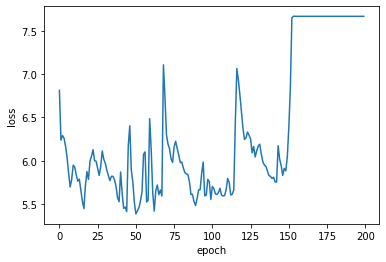

In [0]:
plt_loss = train(hparams, saving=False)
del dataset

plt.plot(plt_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()